<a href="https://colab.research.google.com/github/KevZ3131/Test/blob/main/Copy_of_EMG_tut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install PyWavelets

In [ ]:
%matplotlib inline
import scipy as sp
from scipy import signal
from scipy.io import loadmat
from scipy.signal import butter, filtfilt

import os
import numpy as np
from numpy.fft import fft, fftfreq
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import log_loss, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier

import subprocess

import pywt

In [ ]:
for i in range(1, 11):
    subprocess.run(['wget', f'https://ninapro.hevs.ch/files/DB5_Preproc/s{i}.zip'])
    subprocess.run(['unzip', f's{i}.zip'])
    subprocess.run(['rm', f's{i}.zip'])

In [ ]:
# Example EMG
s1_a1 = loadmat("/content/s1/S1_E1_A1.mat")
s1_e2_a1 = loadmat("/content/s1/S1_E2_A1.mat")
s1_e3_a1 = loadmat("/content/s1/S1_E3_A1.mat")

# Feature Extraction

## Time Domain

### RMS

In [ ]:
window = 2.5 # seconds
sampling_rate = s1_a1['frequency'][0][0]

time_step = int(window*sampling_rate)   # seconds

example = np.array(s1_a1['emg'][:, 1])

In [ ]:
time_step

500

In [ ]:
# RMS
import time


def RMS(signal, time_step):
    start_time = time.time()
    rms_envelope = np.zeros(len(signal))
    # signal = np.pad(signal, [(time_step, time_step)], 'constant', constant_values=0)

    for i in range(len(signal)):
        start = max(0, i - time_step // 2)
        end = min(len(signal), i + time_step // 2)

        window_segment = signal[start:end]

        rms_value = np.sqrt(np.mean(window_segment**2))

        rms_envelope[i] = rms_value

    end_time = time.time()

    return rms_envelope, end_time-start_time

def conv_RMS(signal, time_step):
    start_time = time.time()
    signal = np.power(signal,2)
    window = np.ones(time_step)/float(time_step)
    result = np.sqrt(np.convolve(signal, window, 'valid'))
    end_time = time.time()
    return result, end_time-start_time

filtered, time_rms = RMS(example, time_step)
filtered, time_conv = conv_RMS(example, time_step)


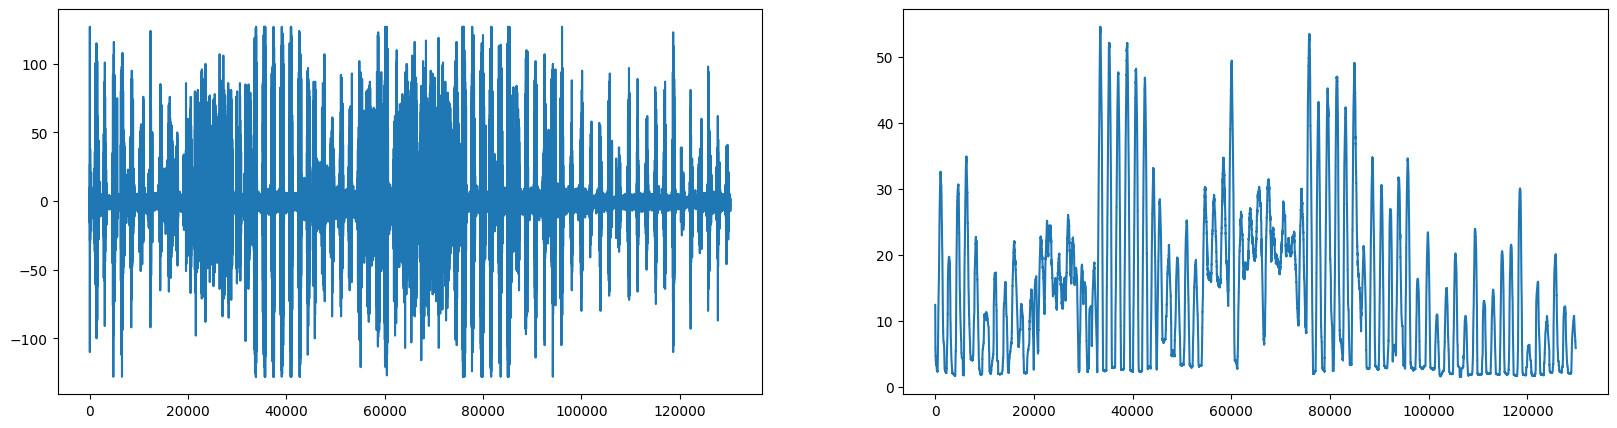

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(example)
ax[1].plot(filtered)
plt.show()

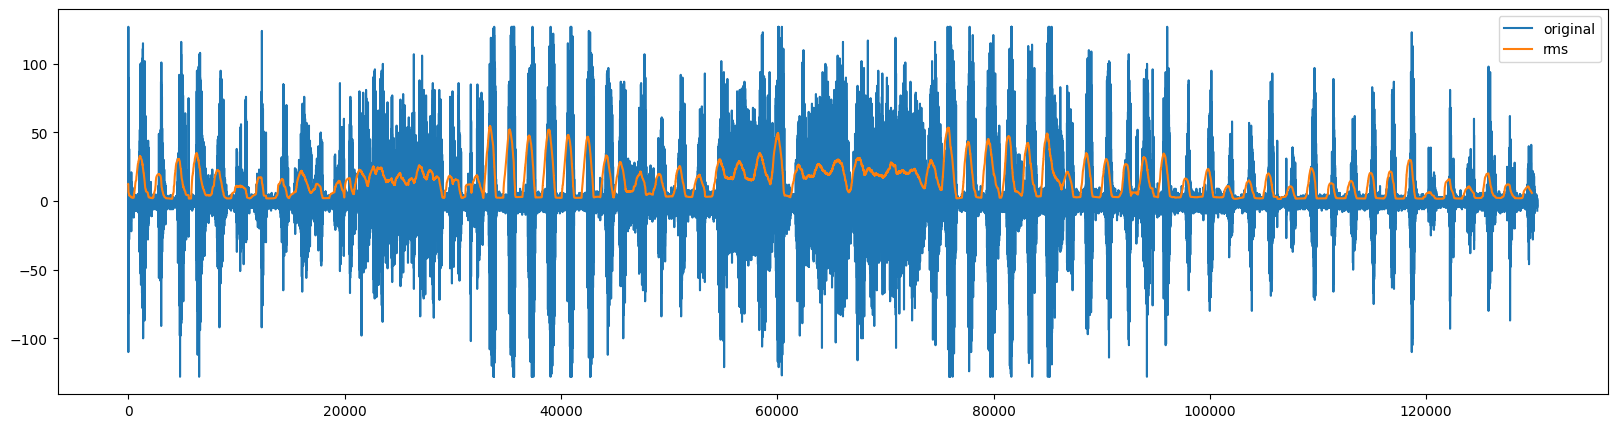

In [ ]:
fig = plt.figure(figsize=(20, 5))
plt.plot(example, label='original')
plt.plot(filtered, label='rms')
plt.legend()
plt.show()

### Weighted Moving Average

In [ ]:
def WMA(emg_signal, window_size):
    emg_signal = np.array(emg_signal)

    weights = np.arange(1, window_size + 1)
    weights = weights / weights.sum()

    wma = np.convolve(emg_signal, weights, mode='same')

    return wma

window_size = 10
wma_env = WMA(example, window_size)

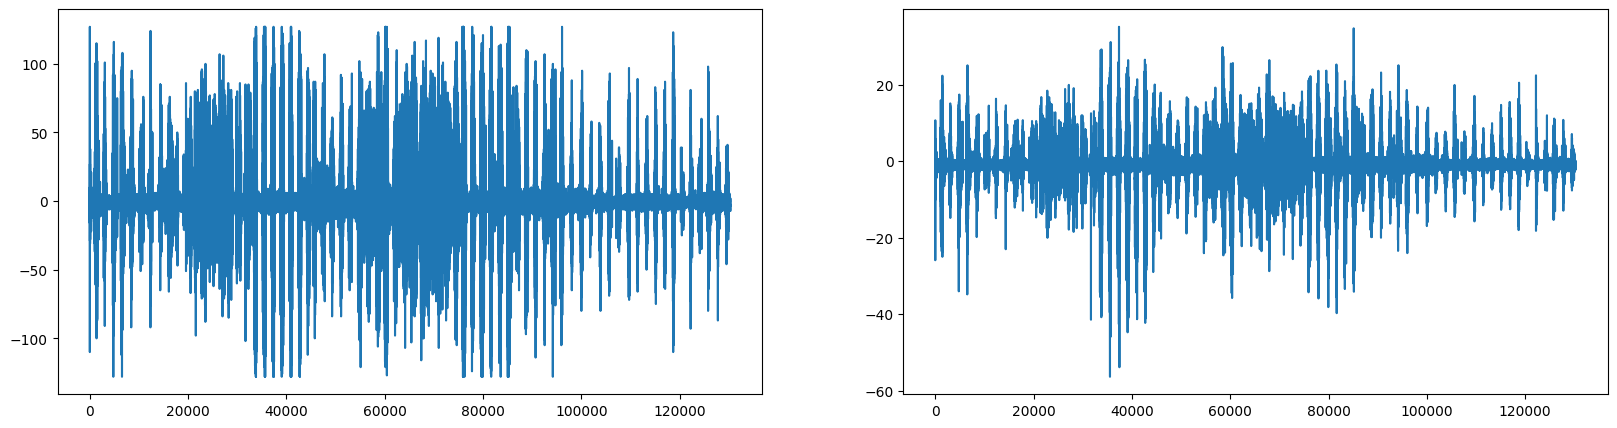

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(example)
ax[1].plot(wma_env)
plt.show()

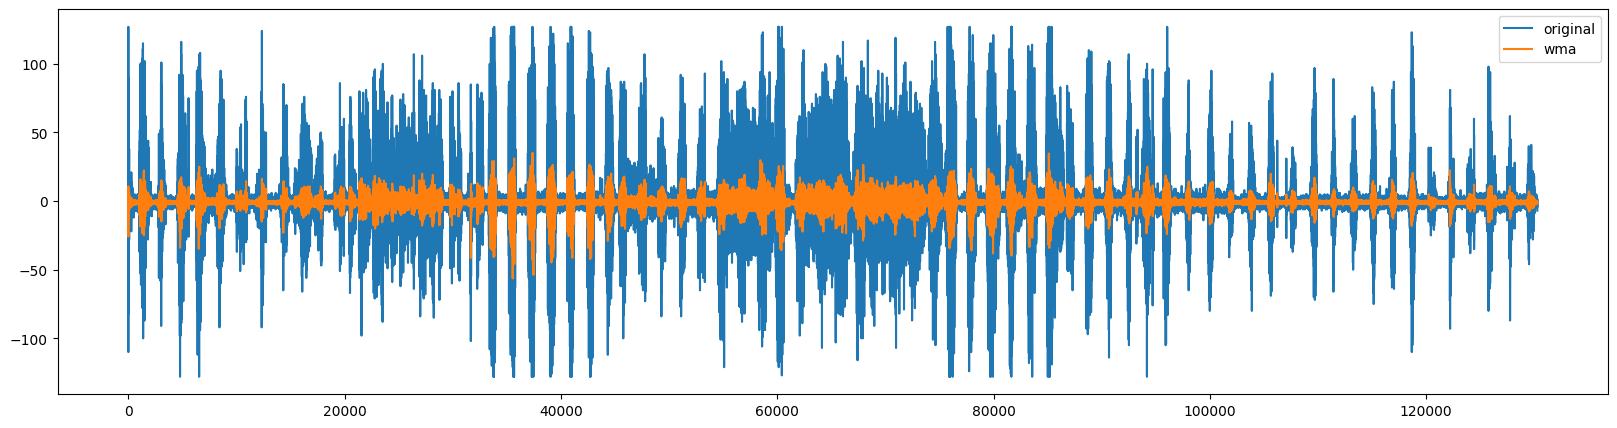

In [ ]:
fig = plt.figure(figsize=(20, 5))
plt.plot(example, label='original')
plt.plot(wma_env, label='wma')
plt.legend()
plt.show()

### Simple Moving Average

In [ ]:
def SMA(emg_signal, window_size):
    return np.convolve(emg_signal, np.ones(window_size)/window_size, mode='same')

window_size = 10
sma_env = SMA(example, window_size)

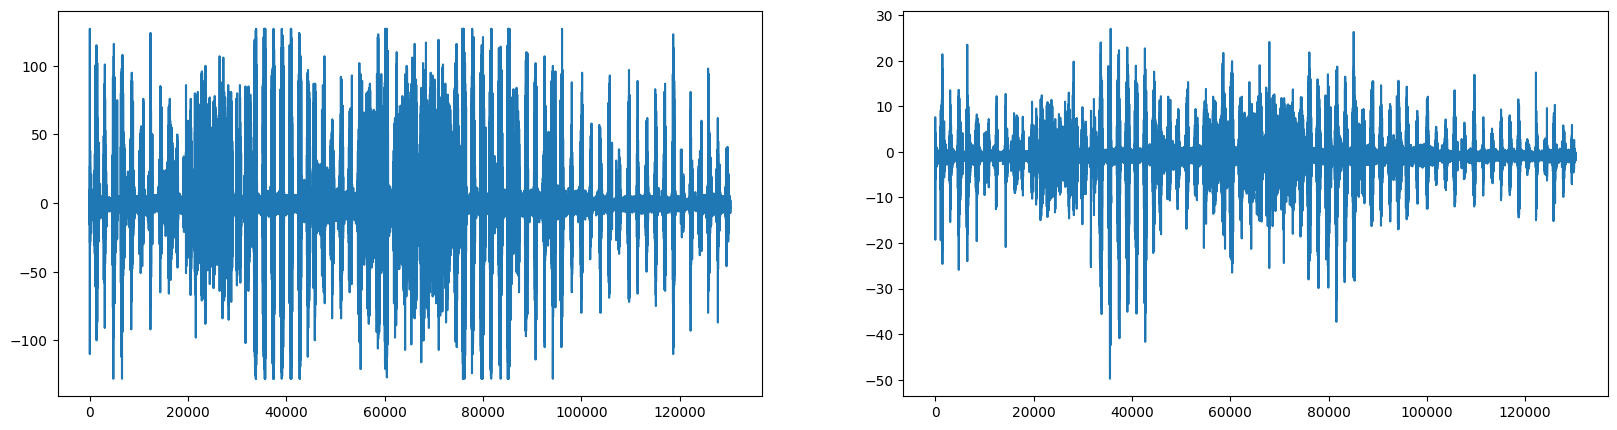

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(example)
ax[1].plot(sma_env)
plt.show()

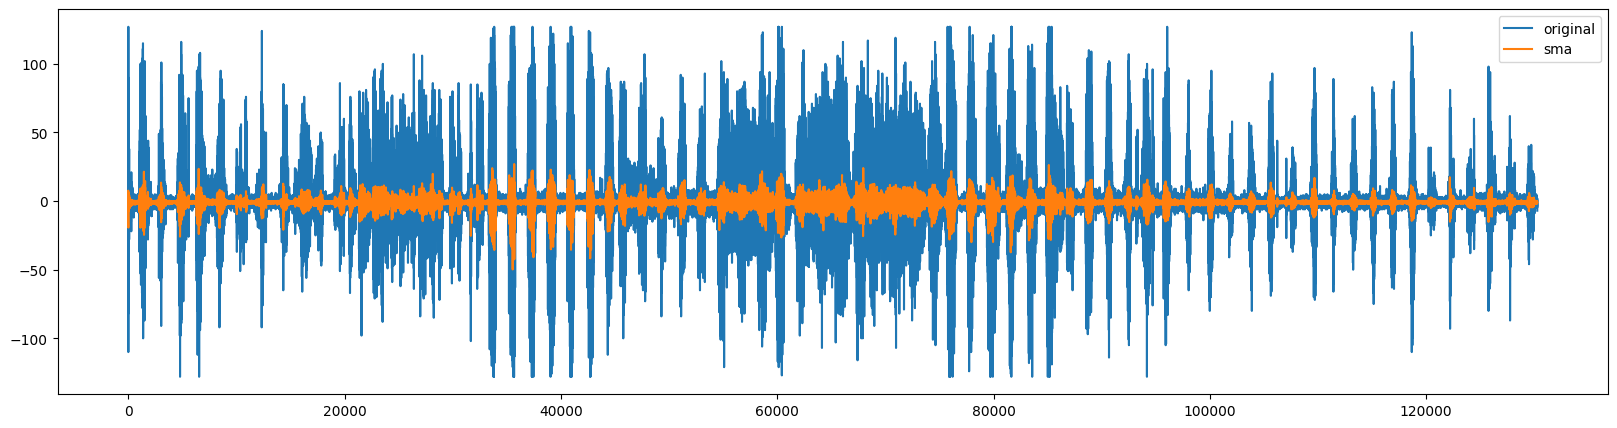

In [ ]:
fig = plt.figure(figsize=(20, 5))
plt.plot(example, label='original')
plt.plot(sma_env, label='sma')
plt.legend()
plt.show()

### Culmulative Moving Average

In [ ]:
def CMA(emg_signal):
    return np.cumsum(emg_signal) / np.arange(1, len(emg_signal) + 1)

cma_env = CMA(example)

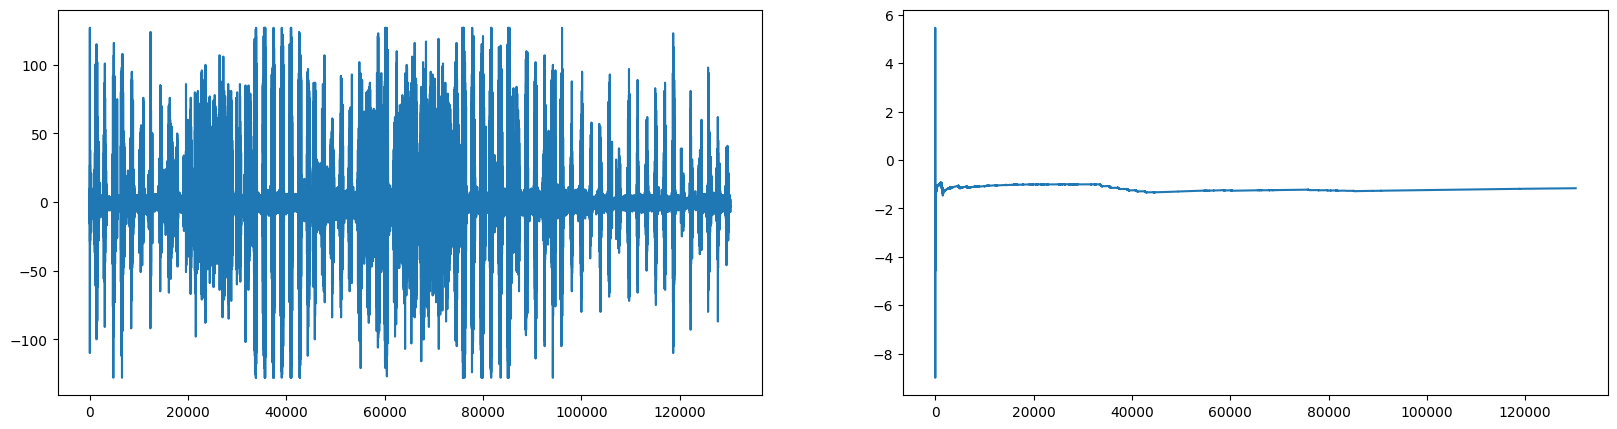

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(example)
ax[1].plot(cma_env)
plt.show()

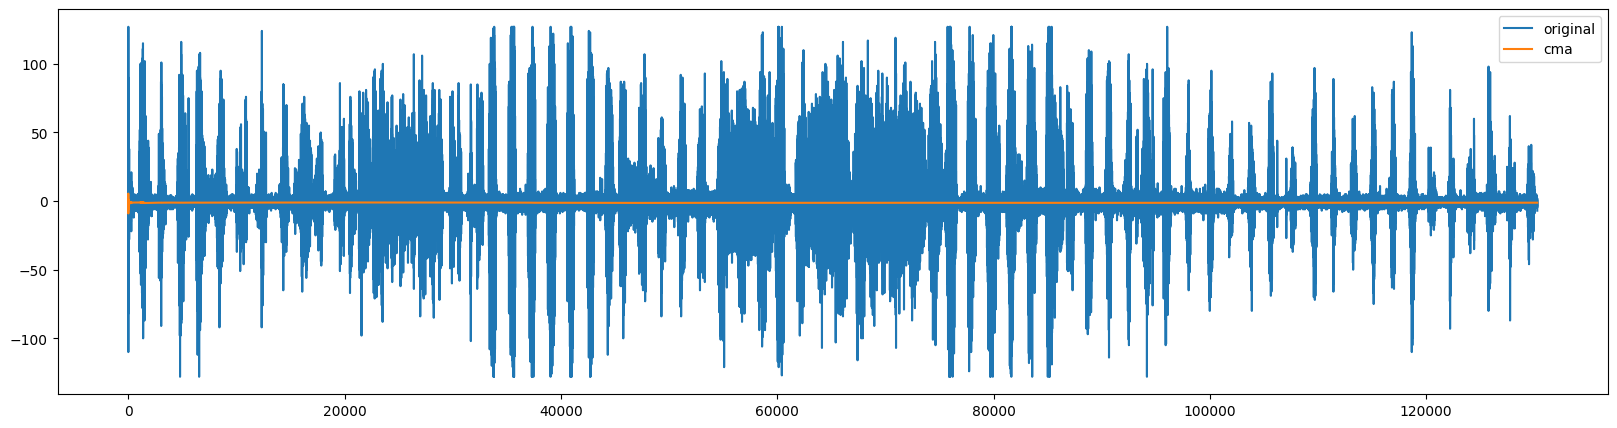

In [ ]:
fig = plt.figure(figsize=(20, 5))
plt.plot(example, label='original')
plt.plot(cma_env, label='cma')
plt.legend()
plt.show()

### Exponential Moving Average

In [ ]:
def EMA(emg_signal, alpha):
    ema = np.zeros(len(emg_signal))
    ema[0] = emg_signal[0]
    for i in range(1, len(emg_signal)):
        ema[i] = alpha * emg_signal[i] + (1 - alpha) * ema[i - 1]
    return ema

alpha = 0.1 # Smoothing
ema_env = EMA(example, alpha)

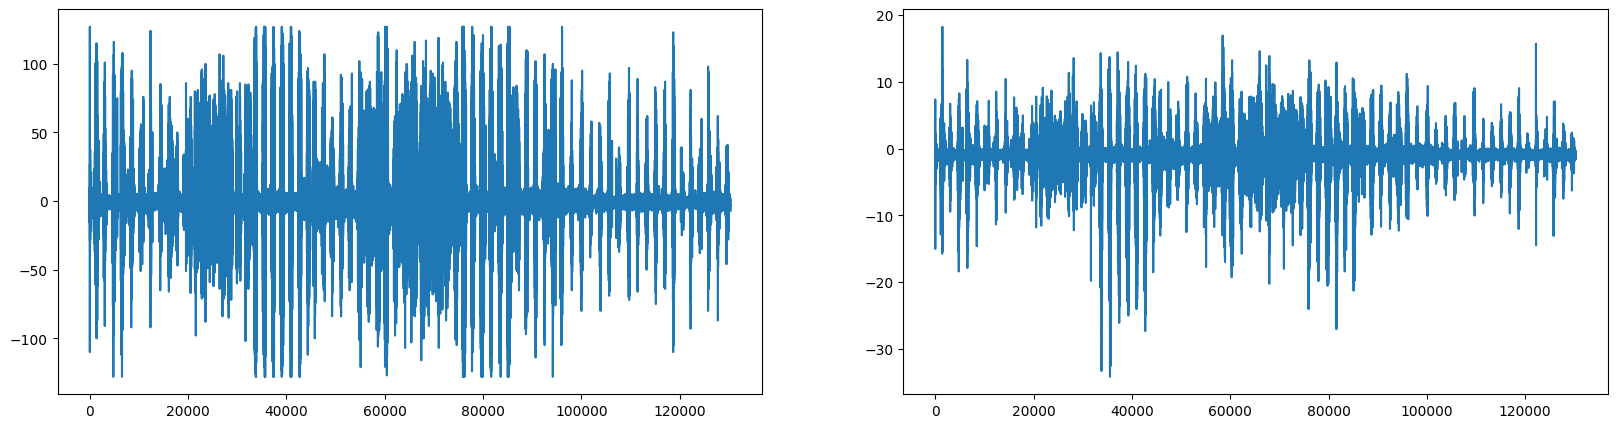

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(example)
ax[1].plot(ema_env)
plt.show()

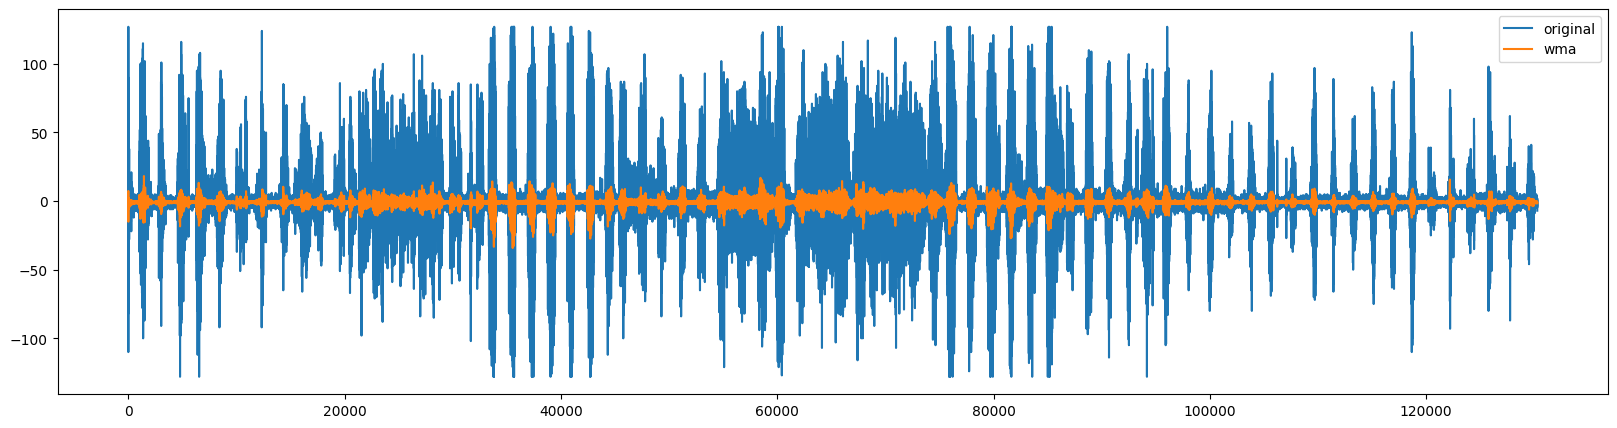

In [ ]:
fig = plt.figure(figsize=(20, 5))
plt.plot(example, label='original')
plt.plot(ema_env, label='wma')
plt.legend()
plt.show()

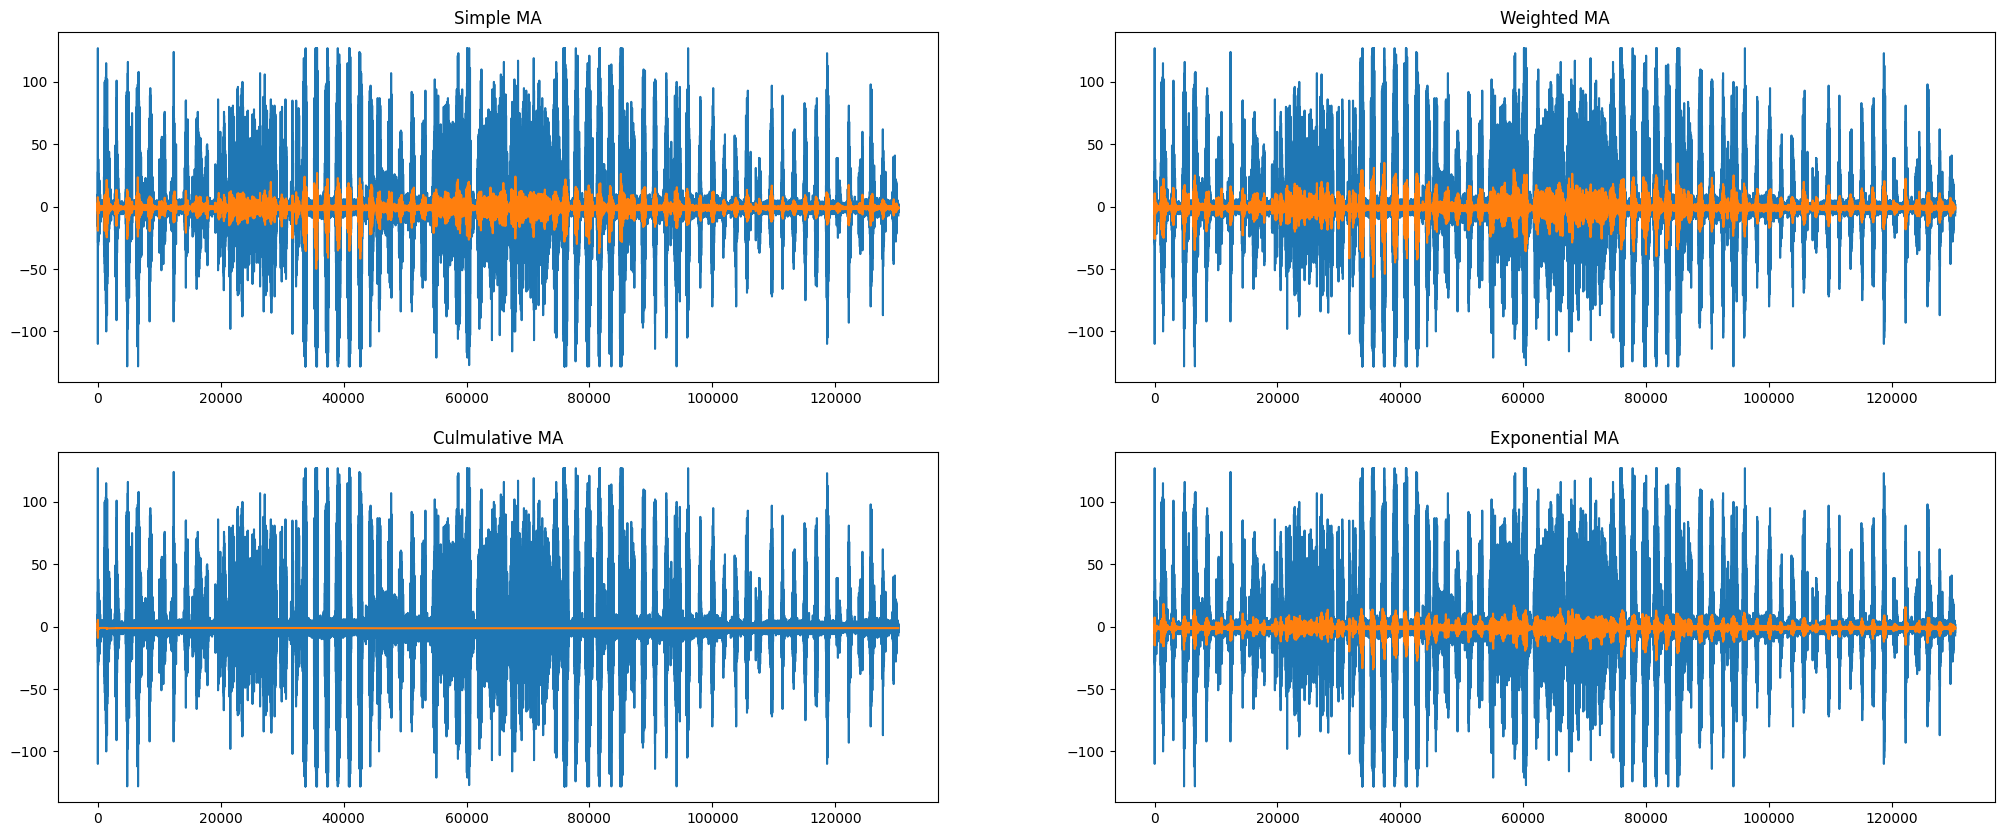

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(25, 10))
ax[0][0].plot(example, label='original')
ax[0][0].plot(sma_env, label='sma')
ax[0][0].set_title("Simple MA")

ax[1][0].plot(example, label='original')
ax[1][0].plot(cma_env, label='cma')
ax[1][0].set_title("Culmulative MA")

ax[0][1].plot(example, label='original')
ax[0][1].plot(wma_env, label='wma')
ax[0][1].set_title("Weighted MA")

ax[1][1].plot(example, label='original')
ax[1][1].plot(ema_env, label='ema')
ax[1][1].set_title("Exponential MA")

plt.show()

## Frequency Domain

### FFT


In [ ]:
sampling_rate = s1_a1['frequency'][0][0]

In [ ]:
nyquist = sampling_rate / 2
freqs = fftfreq(s1_a1['emg'].shape[0], d=1/sampling_rate)
mask = (freqs >= 0)
freqs = freqs[mask]

fft_values = fft(s1_a1['emg'])
fft_values = np.abs(fft_values[mask])

# PSD Power Spectral Density
psd = np.abs(fft_values) ** 2
cumulative_energy = np.cumsum(psd)
total_energy = cumulative_energy[-1]

threshold_energy_low = 0.05 * total_energy
threshold_energy_high = 0.95 * total_energy

low_freq_index = np.searchsorted(cumulative_energy, threshold_energy_low)
high_freq_index = np.searchsorted(cumulative_energy, threshold_energy_high)

# Ensure indices do not exceed array bounds
low_freq_index = min(low_freq_index, len(freqs) - 1)
high_freq_index = min(high_freq_index, len(freqs) - 1)

# Determine cutoff frequencies
low_cutoff_freq = freqs[low_freq_index]
high_cutoff_freq = freqs[high_freq_index]

print(f"Low Cutoff Frequency: {low_cutoff_freq} Hz")
print(f"High Cutoff Frequency: {high_cutoff_freq} Hz")

low_cutoff_freq = 10     # Hertz
high_cutoff_freq = 150  # Hertz

if high_cutoff_freq > nyquist:
    high_cutoff_freq = nyquist - low_cutoff_freq

# Basically High is the last frequency before noise in the upper range
# Low is the last frequenct before noise in the lower range

print(f"Low Cutoff Frequency: {low_cutoff_freq} Hz")
print(f"High Cutoff Frequency: {high_cutoff_freq} Hz")

low = low_cutoff_freq / nyquist
high = high_cutoff_freq / nyquist

b, a = butter(N=4, Wn=[low, high], btype='band')
filtered_signal = filtfilt(b, a, s1_a1['emg'], axis=0)
rectified = np.abs(filtered_signal)

b, a = butter(N=4, Wn=0.5, btype='lowpass')
filtered_signal = filtfilt(b, a, filtered_signal, axis=0)
rectified = np.abs(filtered_signal)


Low Cutoff Frequency: 99.99923234587423 Hz
High Cutoff Frequency: 99.99923234587423 Hz
Low Cutoff Frequency: 10 Hz
High Cutoff Frequency: 90.0 Hz


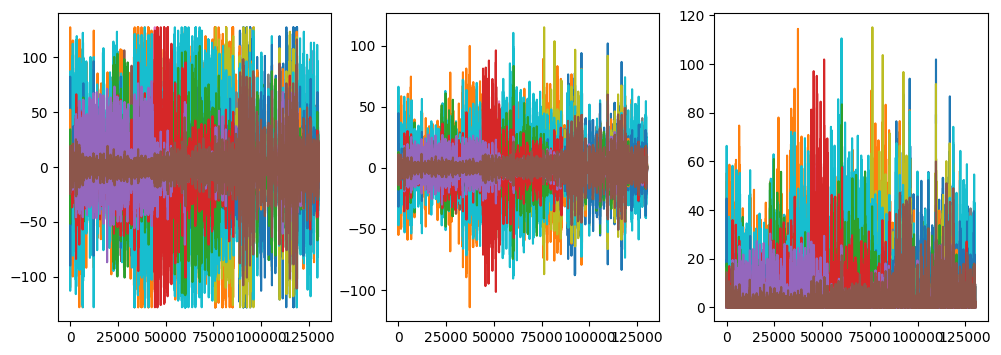

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(s1_a1['emg'])
ax[1].plot(filtered_signal)
ax[2].plot(rectified)
plt.show()

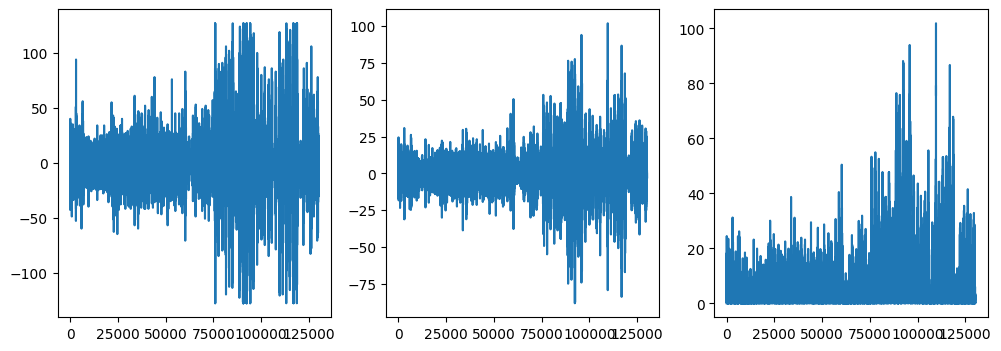

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(s1_a1['emg'][:, 0])
ax[1].plot(filtered_signal[:, 0])
ax[2].plot(rectified[:, 0])
plt.show()

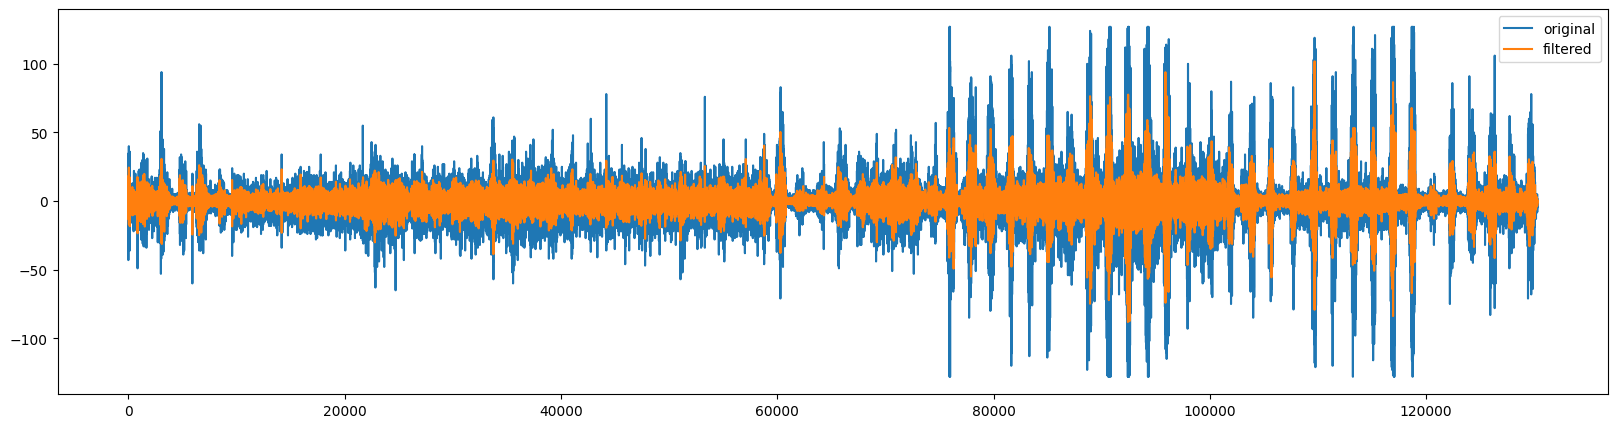

In [ ]:
fig = plt.figure(figsize=(20, 5))
plt.plot(s1_a1['emg'][:, 0], label='original')
plt.plot(filtered_signal[:, 0], label='filtered')
plt.legend()
plt.show()

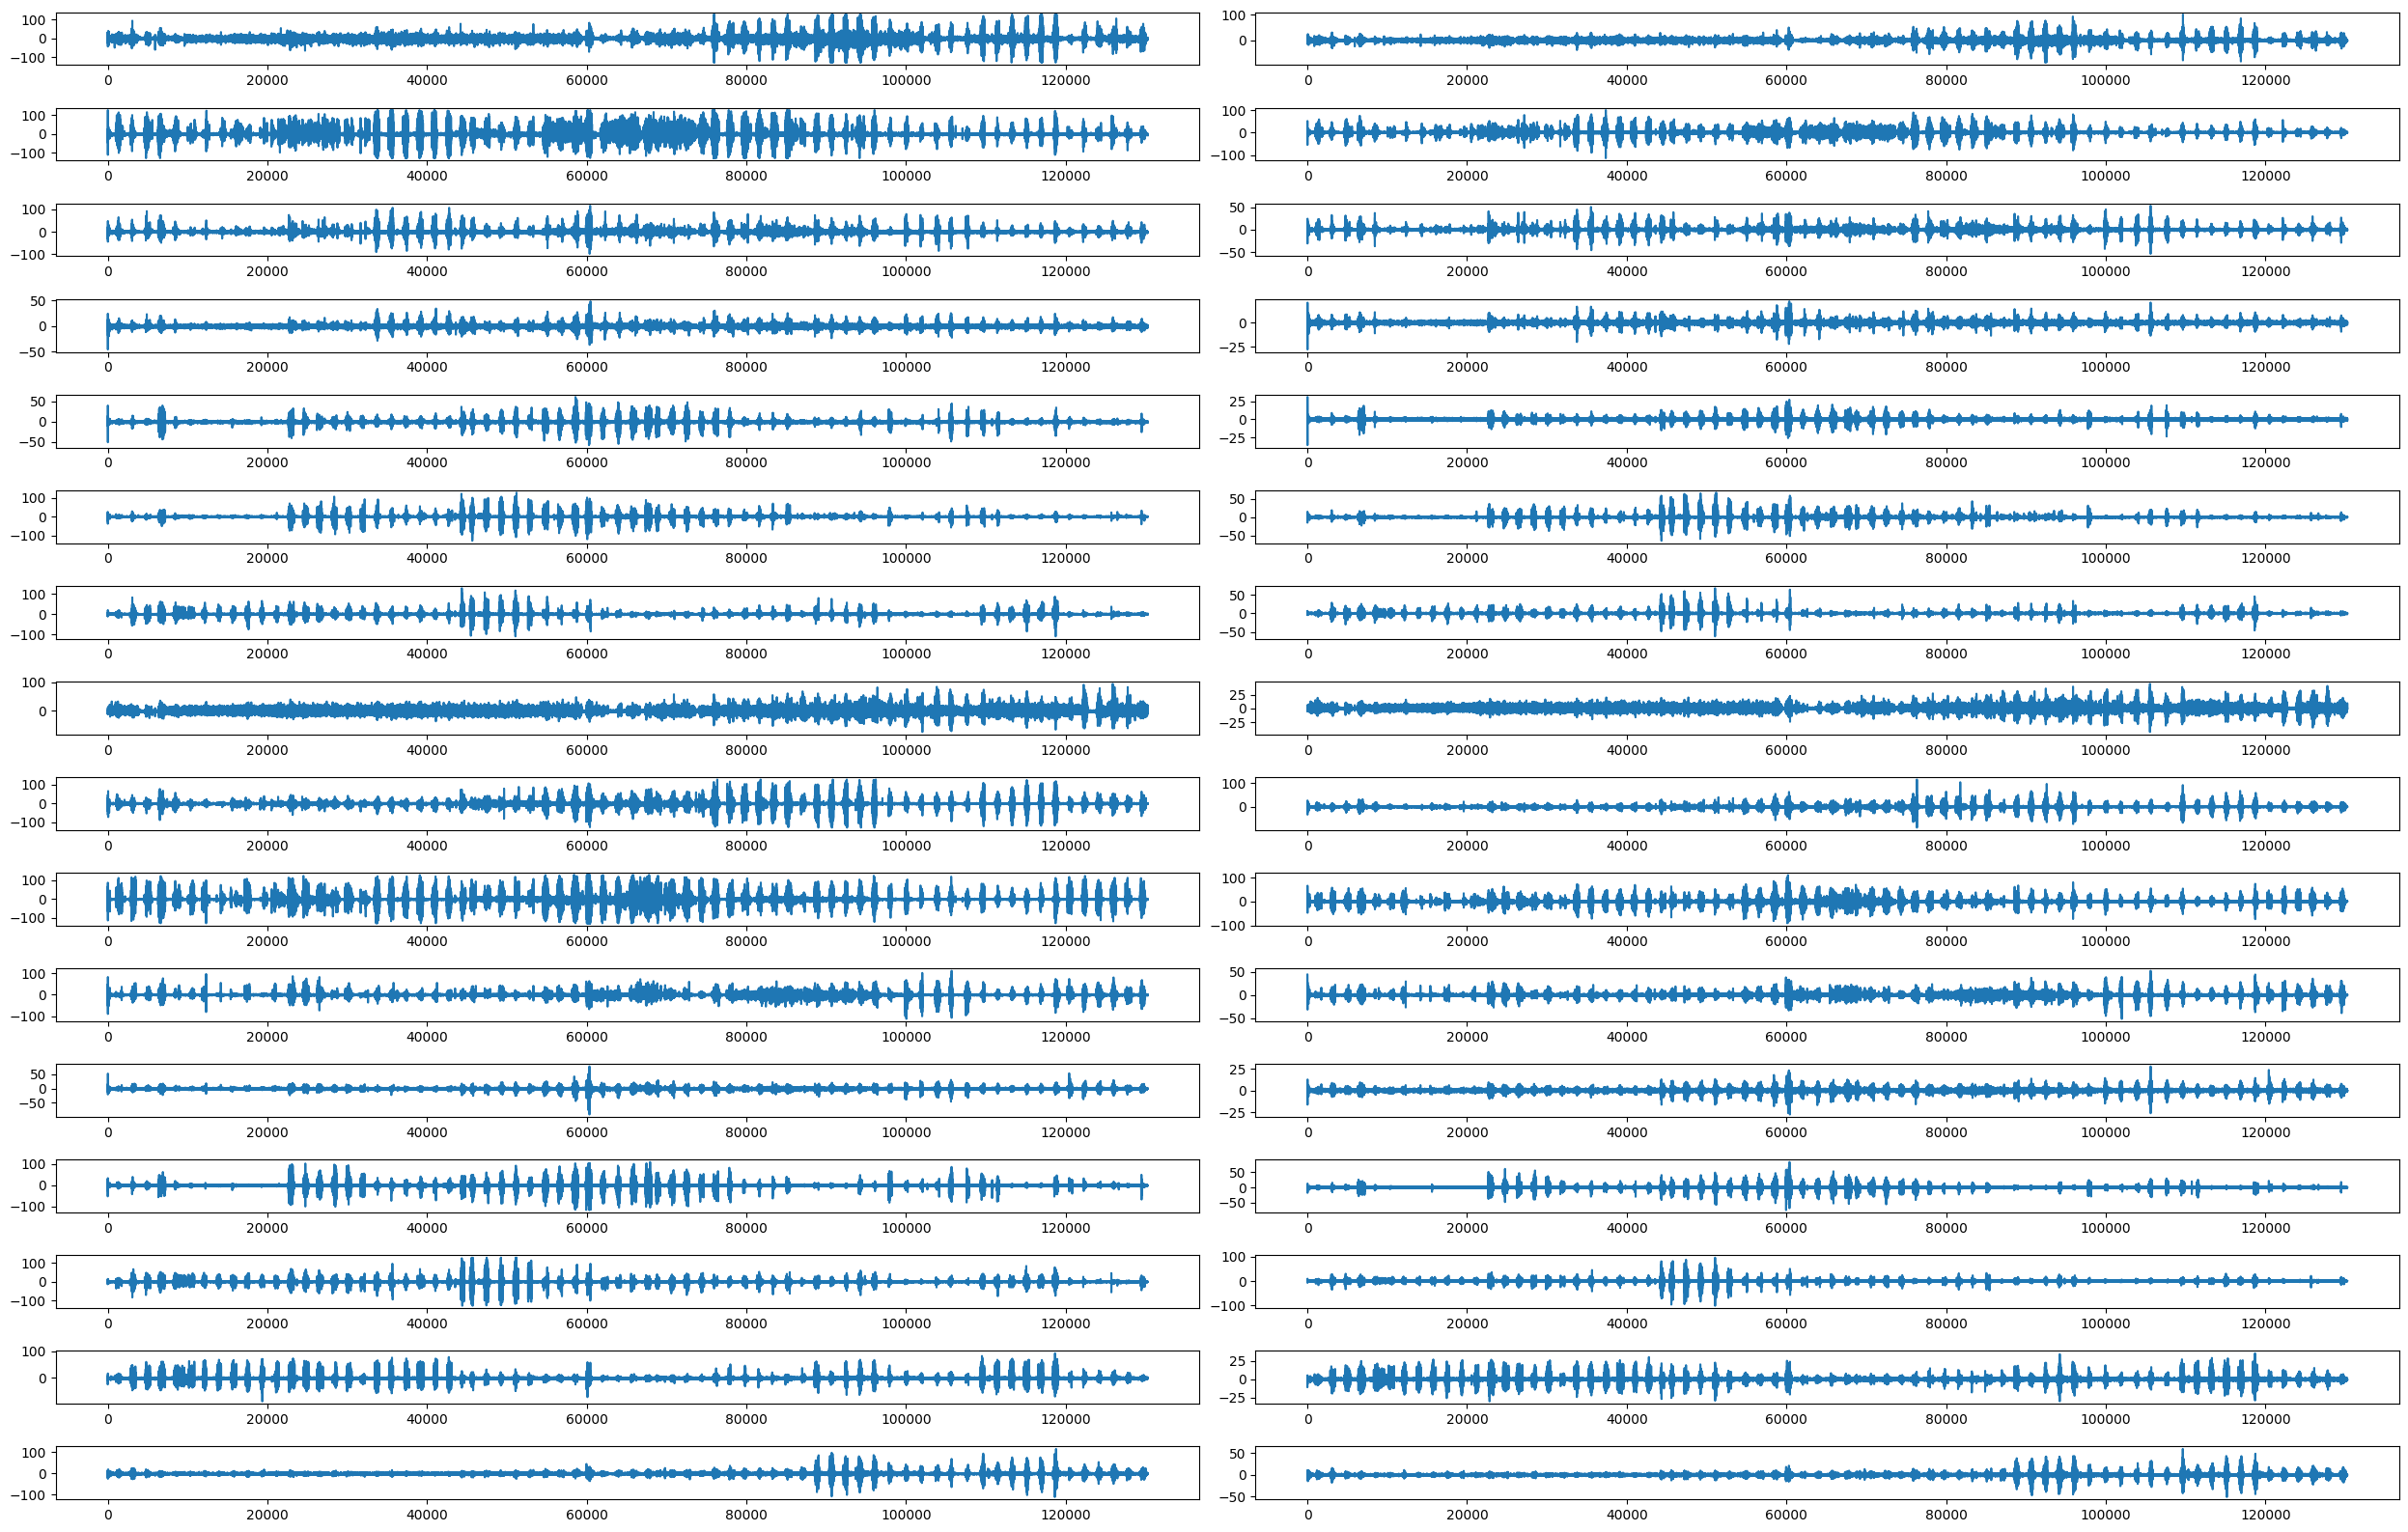

In [ ]:
fig, ax = plt.subplots(16, 2, figsize=(25, 16))
fig.tight_layout()
for i in range(s1_a1['emg'].shape[1]):
    ax[i, 0].plot(s1_a1['emg'][:, i])
    ax[i, 1].plot(filtered_signal[:, i])
plt.show()

In [ ]:
signal_fft = fft(s1_a1['emg'])[:, 0]
filtered_fft = fft(filtered_signal[:, 0])

freqs = fftfreq(s1_a1['emg'].shape[0], d=1/sampling_rate)
freqs_positive = freqs[:s1_a1['emg'].shape[0]//2]

filtered_freqs = fftfreq(filtered_signal.shape[0], d=1/sampling_rate)
filtered_freqs_positive = filtered_freqs[:filtered_signal.shape[0]//2]

signal_fft_positive = signal_fft[:s1_a1['emg'].shape[0]//2]
filtered_fft_positive = filtered_fft[:filtered_signal.shape[0]//2]

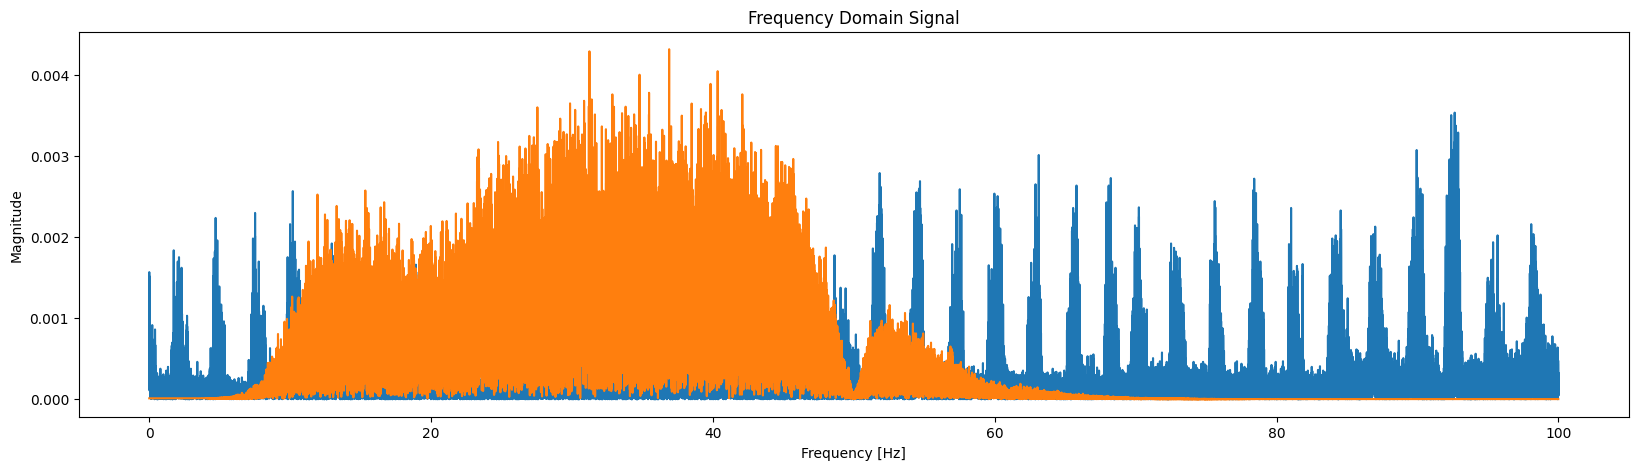

In [ ]:
fig = plt.figure(figsize=(20, 5))
plt.plot(freqs_positive, np.abs(signal_fft_positive) / s1_a1['emg'].shape[0], label='signal')
plt.plot(filtered_freqs_positive, np.abs(filtered_fft_positive) / filtered_signal.shape[0] / 25, label='filtered')
plt.title('Frequency Domain Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.show()

## PSD

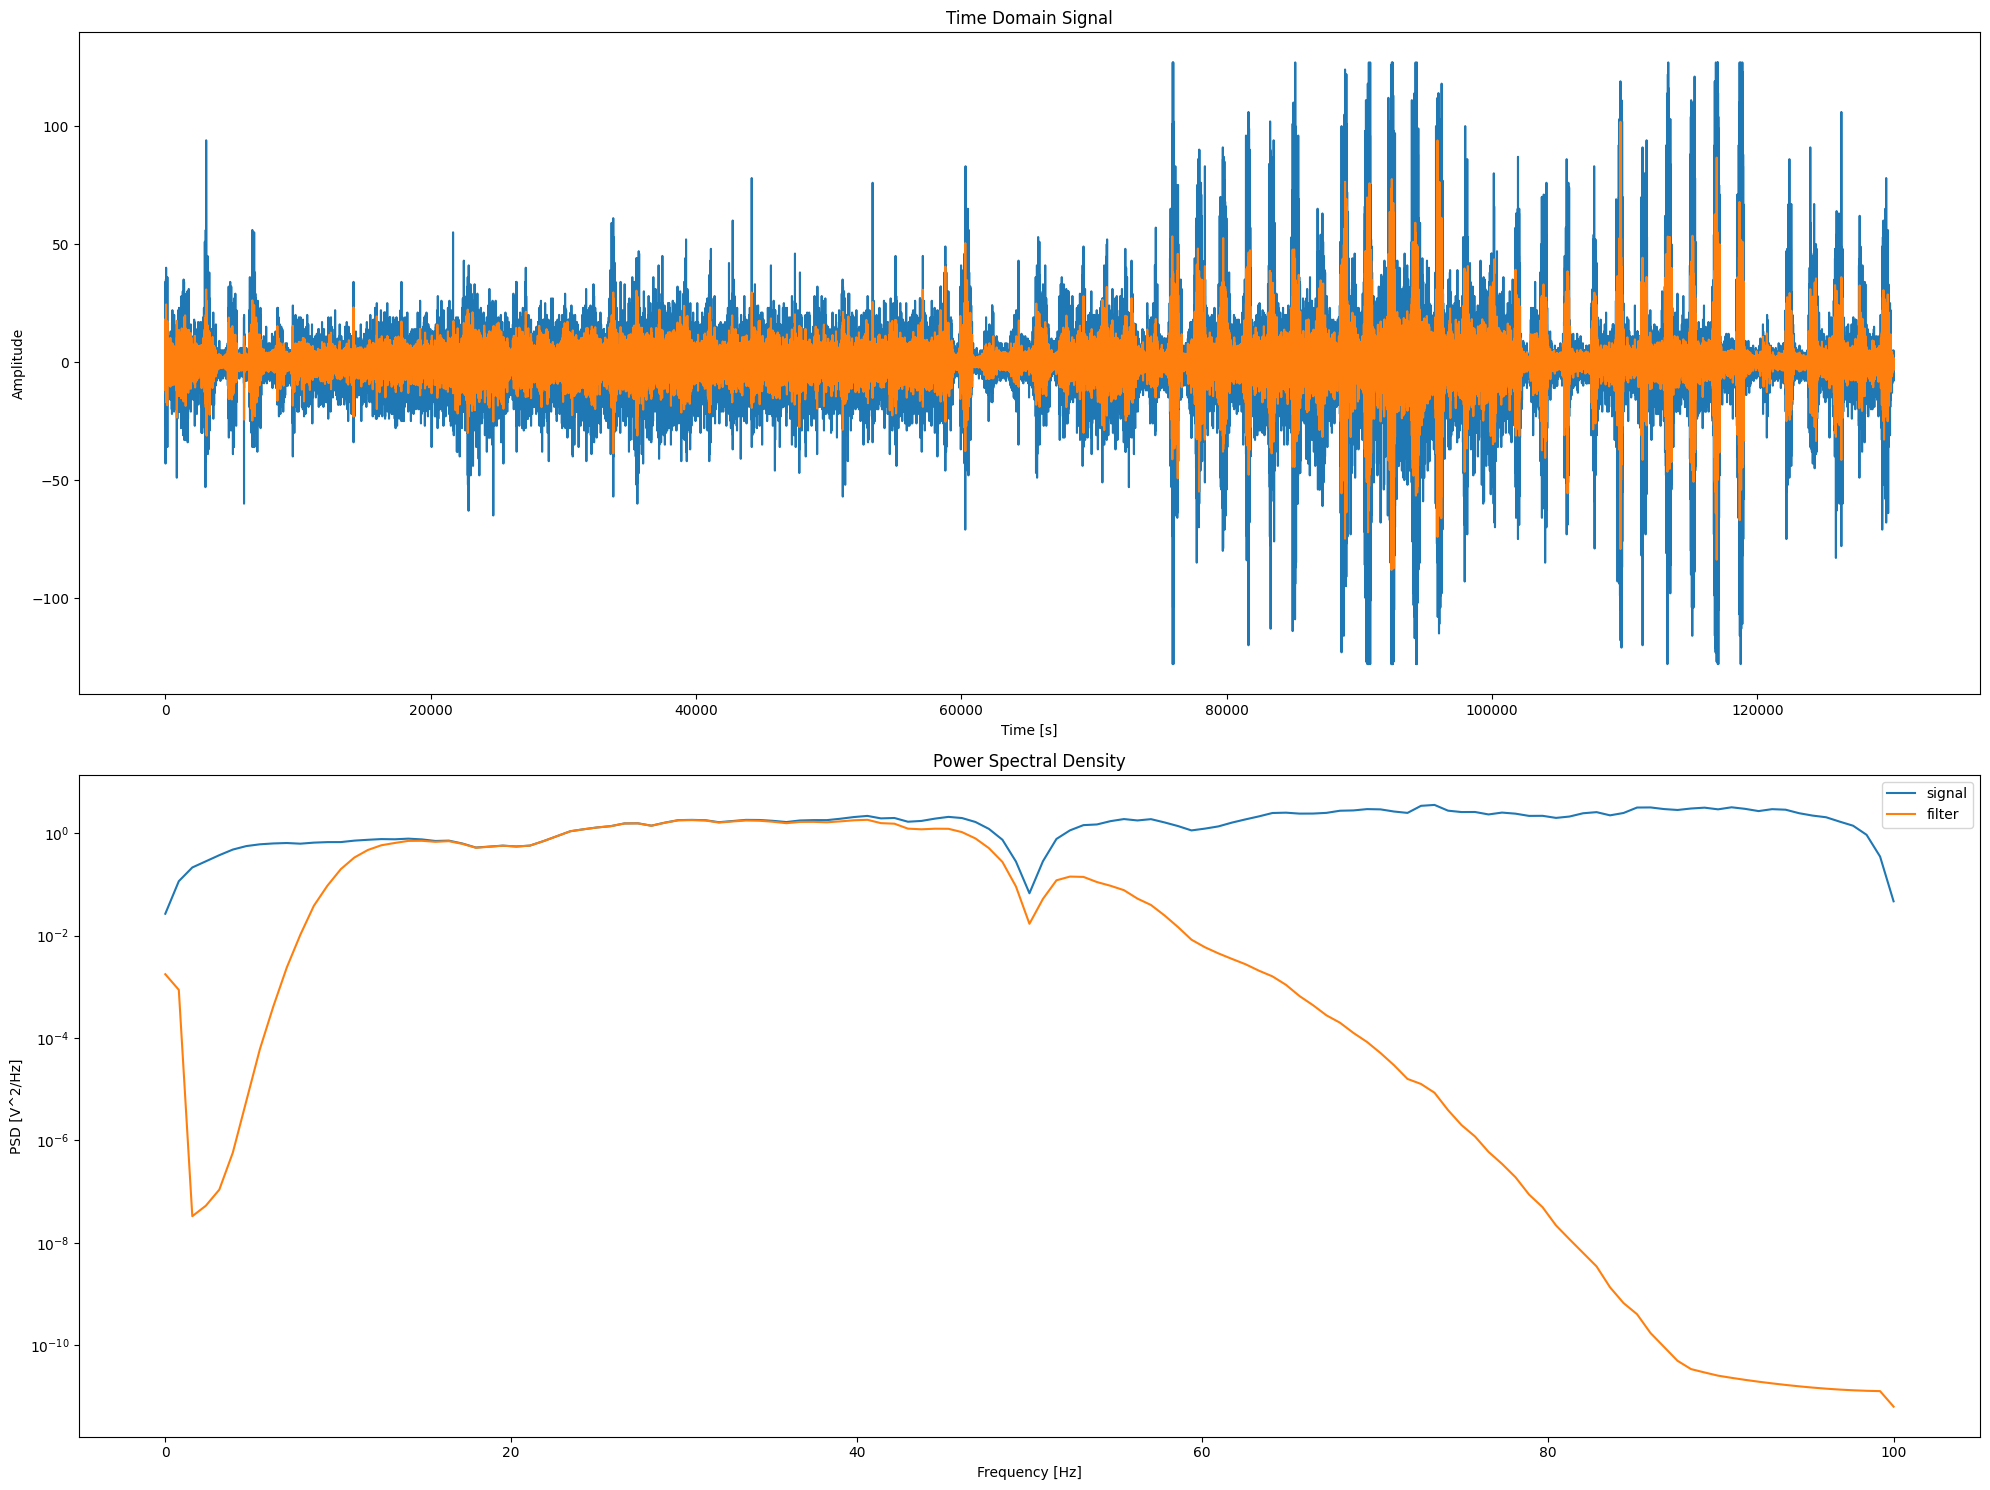

In [ ]:
from scipy.signal import welch

freqs, psd = welch(s1_a1['emg'][:, 0], fs=sampling_rate)
filtered_freqs, filtered_psd = welch(filtered_signal[:, 0], fs=sampling_rate)

plt.figure(figsize=(20, 15))

plt.subplot(2, 1, 1)
plt.plot(s1_a1['emg'][:, 0], label='signal')
plt.plot(filtered_signal[:, 0], label='filter')
plt.title('Time Domain Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.semilogy(freqs, psd, label='signal')
plt.semilogy(filtered_freqs, filtered_psd, label='filter')
plt.title('Power Spectral Density')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V^2/Hz]')
plt.legend()

plt.tight_layout()
plt.show()

## Mean Frequency MNF

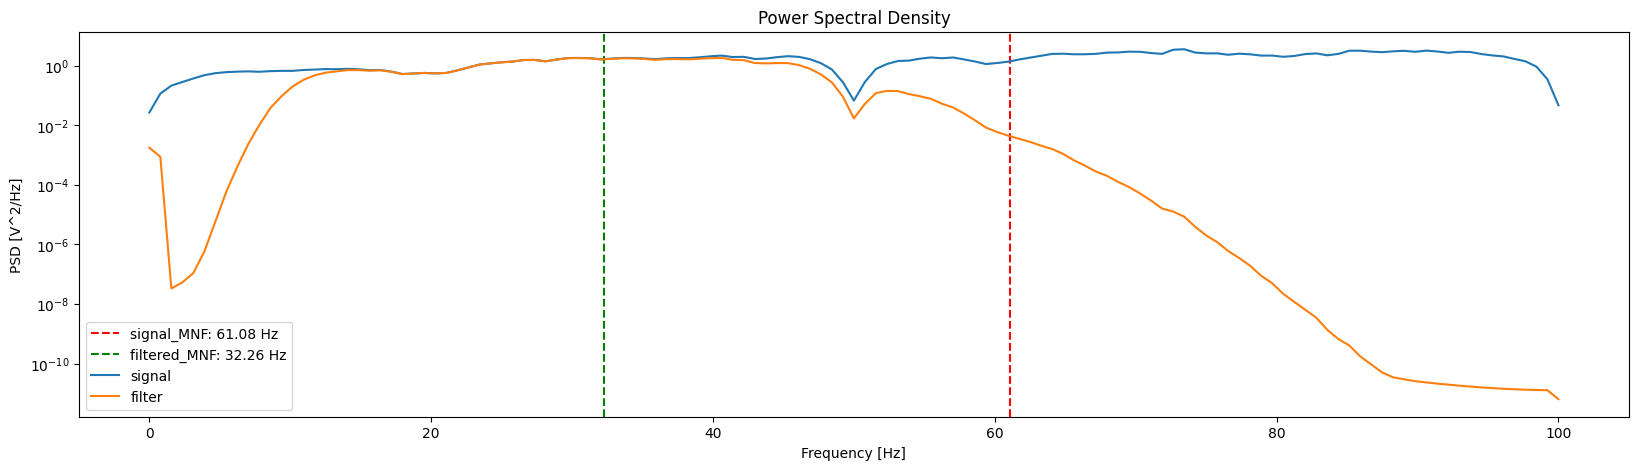

In [ ]:
signal_MNF = np.sum(freqs * psd) / np.sum(psd)
filtered_MNF = np.sum(filtered_freqs * filtered_psd) / np.sum(filtered_psd)


fig = plt.figure(figsize=(20, 5))
plt.axvline(signal_MNF, color='r', linestyle='--', label=f'signal_MNF: {signal_MNF:.2f} Hz')
plt.axvline(filtered_MNF, color='g', linestyle='--', label=f'filtered_MNF: {filtered_MNF:.2f} Hz')

plt.semilogy(freqs, psd, label='signal')
plt.semilogy(filtered_freqs, filtered_psd, label='filter')
plt.title('Power Spectral Density')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V^2/Hz]')
plt.legend()

## Median Frequency MDF

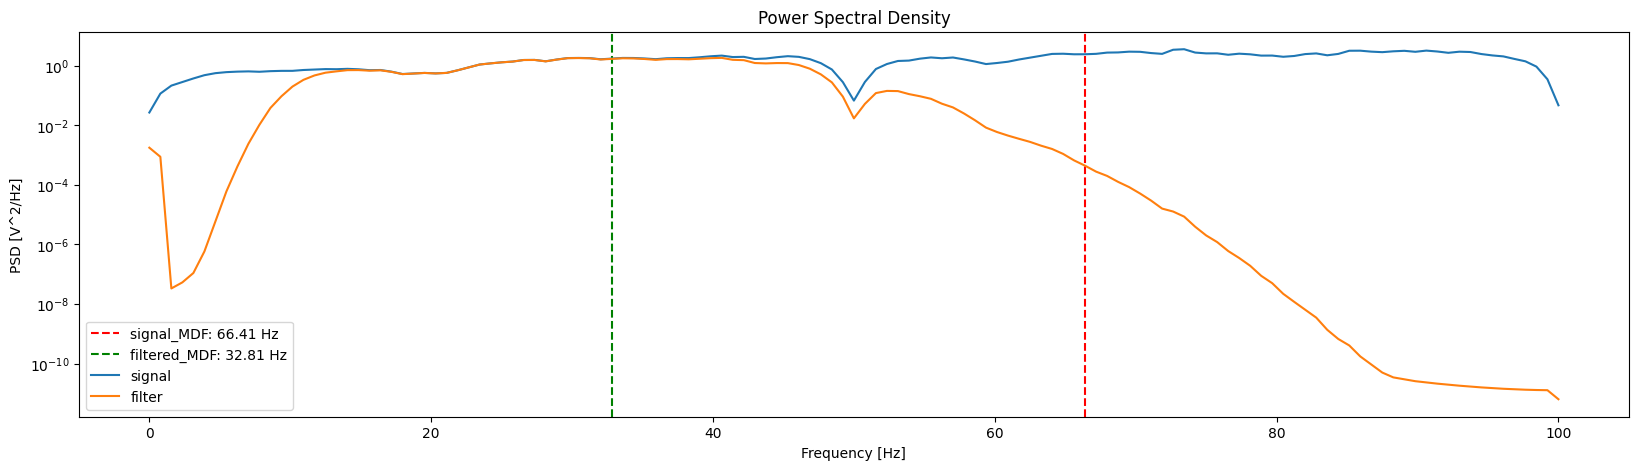

In [ ]:
signal_cumulative_sum = np.cumsum(psd)
filtered_cumulative_sum = np.cumsum(filtered_psd)

signal_MDF = freqs[np.where(signal_cumulative_sum >= 0.5 * np.sum(psd))[0][0]]
filtered_MDF = filtered_freqs[np.where(filtered_cumulative_sum >= 0.5 * np.sum(filtered_psd))[0][0]]

fig = plt.figure(figsize=(20, 5))
plt.axvline(signal_MDF, color='r', linestyle='--', label=f'signal_MDF: {signal_MDF:.2f} Hz')
plt.axvline(filtered_MDF, color='g', linestyle='--', label=f'filtered_MDF: {filtered_MDF:.2f} Hz')

plt.semilogy(freqs, psd, label='signal')
plt.semilogy(filtered_freqs, filtered_psd, label='filter')
plt.title('Power Spectral Density')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V^2/Hz]')
plt.legend()

## PCA and ICA

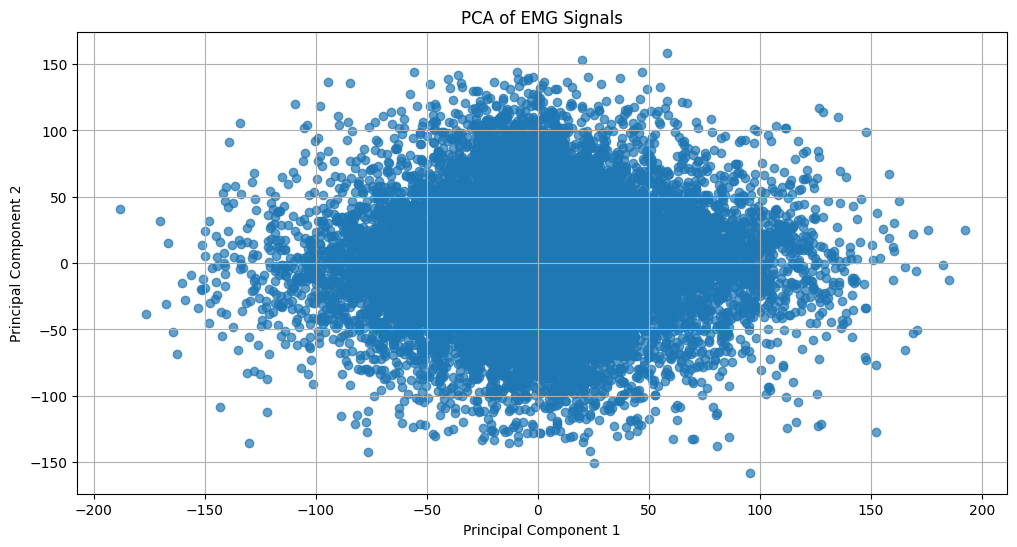

Explained variance by principal components: [0.26980913 0.24176829]


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(s1_a1['emg'])

plt.figure(figsize=(12, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
plt.title('PCA of EMG Signals')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by principal components: {explained_variance}')

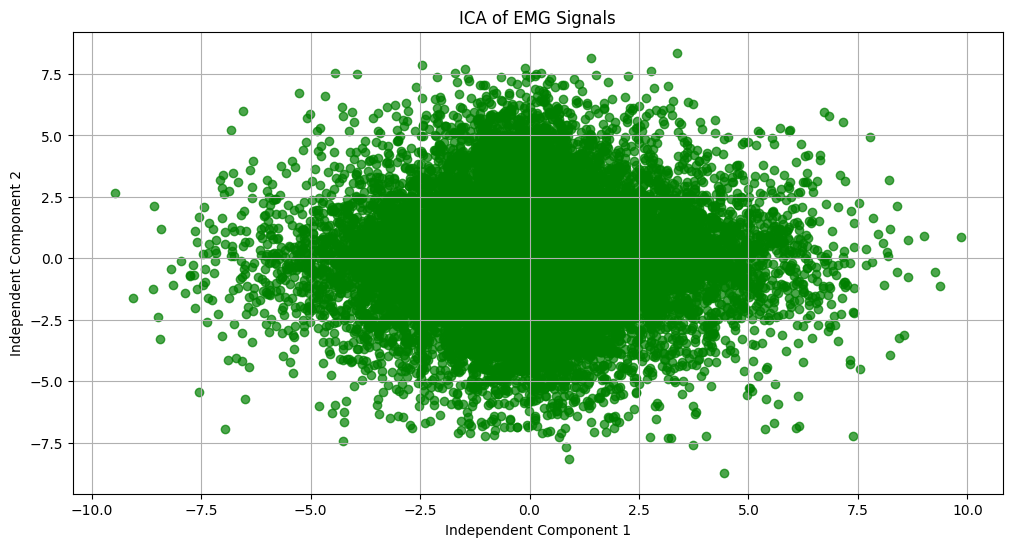

In [ ]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=2, random_state=0)
ica_result = ica.fit_transform(s1_a1['emg'])

# Plot the results
plt.figure(figsize=(12, 6))
plt.scatter(ica_result[:, 0], ica_result[:, 1], alpha=0.7, color='g')
plt.title('ICA of EMG Signals')
plt.xlabel('Independent Component 1')
plt.ylabel('Independent Component 2')
plt.grid(True)
plt.show()

## Frequency and Time Domain

### Wavelet

In [ ]:
wavelets = ['sym4', 'db4']
levels = [2, 3, 5]  # Different levels of decomposition

transformed_data = {}

for wavelet in wavelets:
    for level in levels:
        key = f'{wavelet}_level_{level}'
        transformed_data[key] = []
        for channel in range(s1_a1['emg'].shape[1]):
            coeffs = pywt.wavedec(s1_a1['emg'][:, channel], wavelet, level=level)
            transformed_data[key].append(coeffs)

In [ ]:
# Sym Wavelet
wavelet = 'sym4'
level = 2

transformed_data = []

for i in range(s1_a1['emg'].shape[1]):
    coeffs = pywt.wavedec(s1_a1['emg'][:, i], wavelet, level=level)
    transformed_data.append(coeffs)

In [ ]:
# Daubechies Wavelet
wavelet = 'db4'
level = 5

transformed_data = []

for i in range(s1_a1['emg'].shape[1]):
    coeffs = pywt.wavedec(s1_a1['emg'][:, i], wavelet, level=level)
    transformed_data.append(coeffs)

In [ ]:
transformed_data[0]

[array([ -8.86444 , -10.278995,  -7.624597, ...,  -5.122812,  -7.655284,
        -22.40937 ], dtype=float32),
 array([-1.2287337, -3.8302498,  3.9098306, ...,  1.0016536,  3.1336758,
        -1.6957208], dtype=float32),
 array([-0.35933745, -1.7685856 , -3.5616987 , ...,  7.0396132 ,
        -5.1823144 ,  4.2691507 ], dtype=float32),
 array([ 7.685319  , 25.299437  ,  0.42538446, ...,  1.1356405 ,
         2.6104612 , -3.1387882 ], dtype=float32),
 array([ -6.6735544 , -20.15563   ,  13.18447   , ...,  -0.57655364,
         -1.2588943 ,  -1.6041793 ], dtype=float32),
 array([ -3.7869549, -14.2057295,  -9.543809 , ...,  -5.465366 ,
          0.6192916,  -1.9355491], dtype=float32)]

ValueError: Input could not be cast to an at-least-1D NumPy array

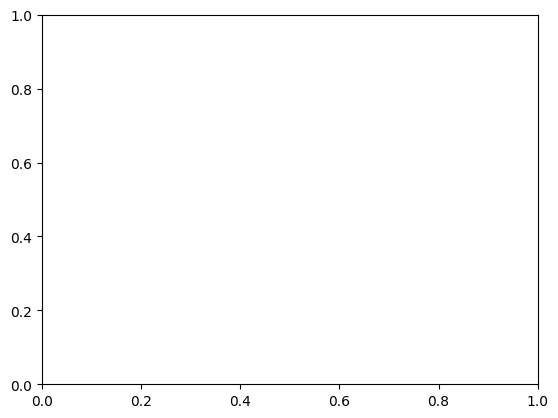

In [ ]:
plt.plot(transformed_data[0])
plt.show()

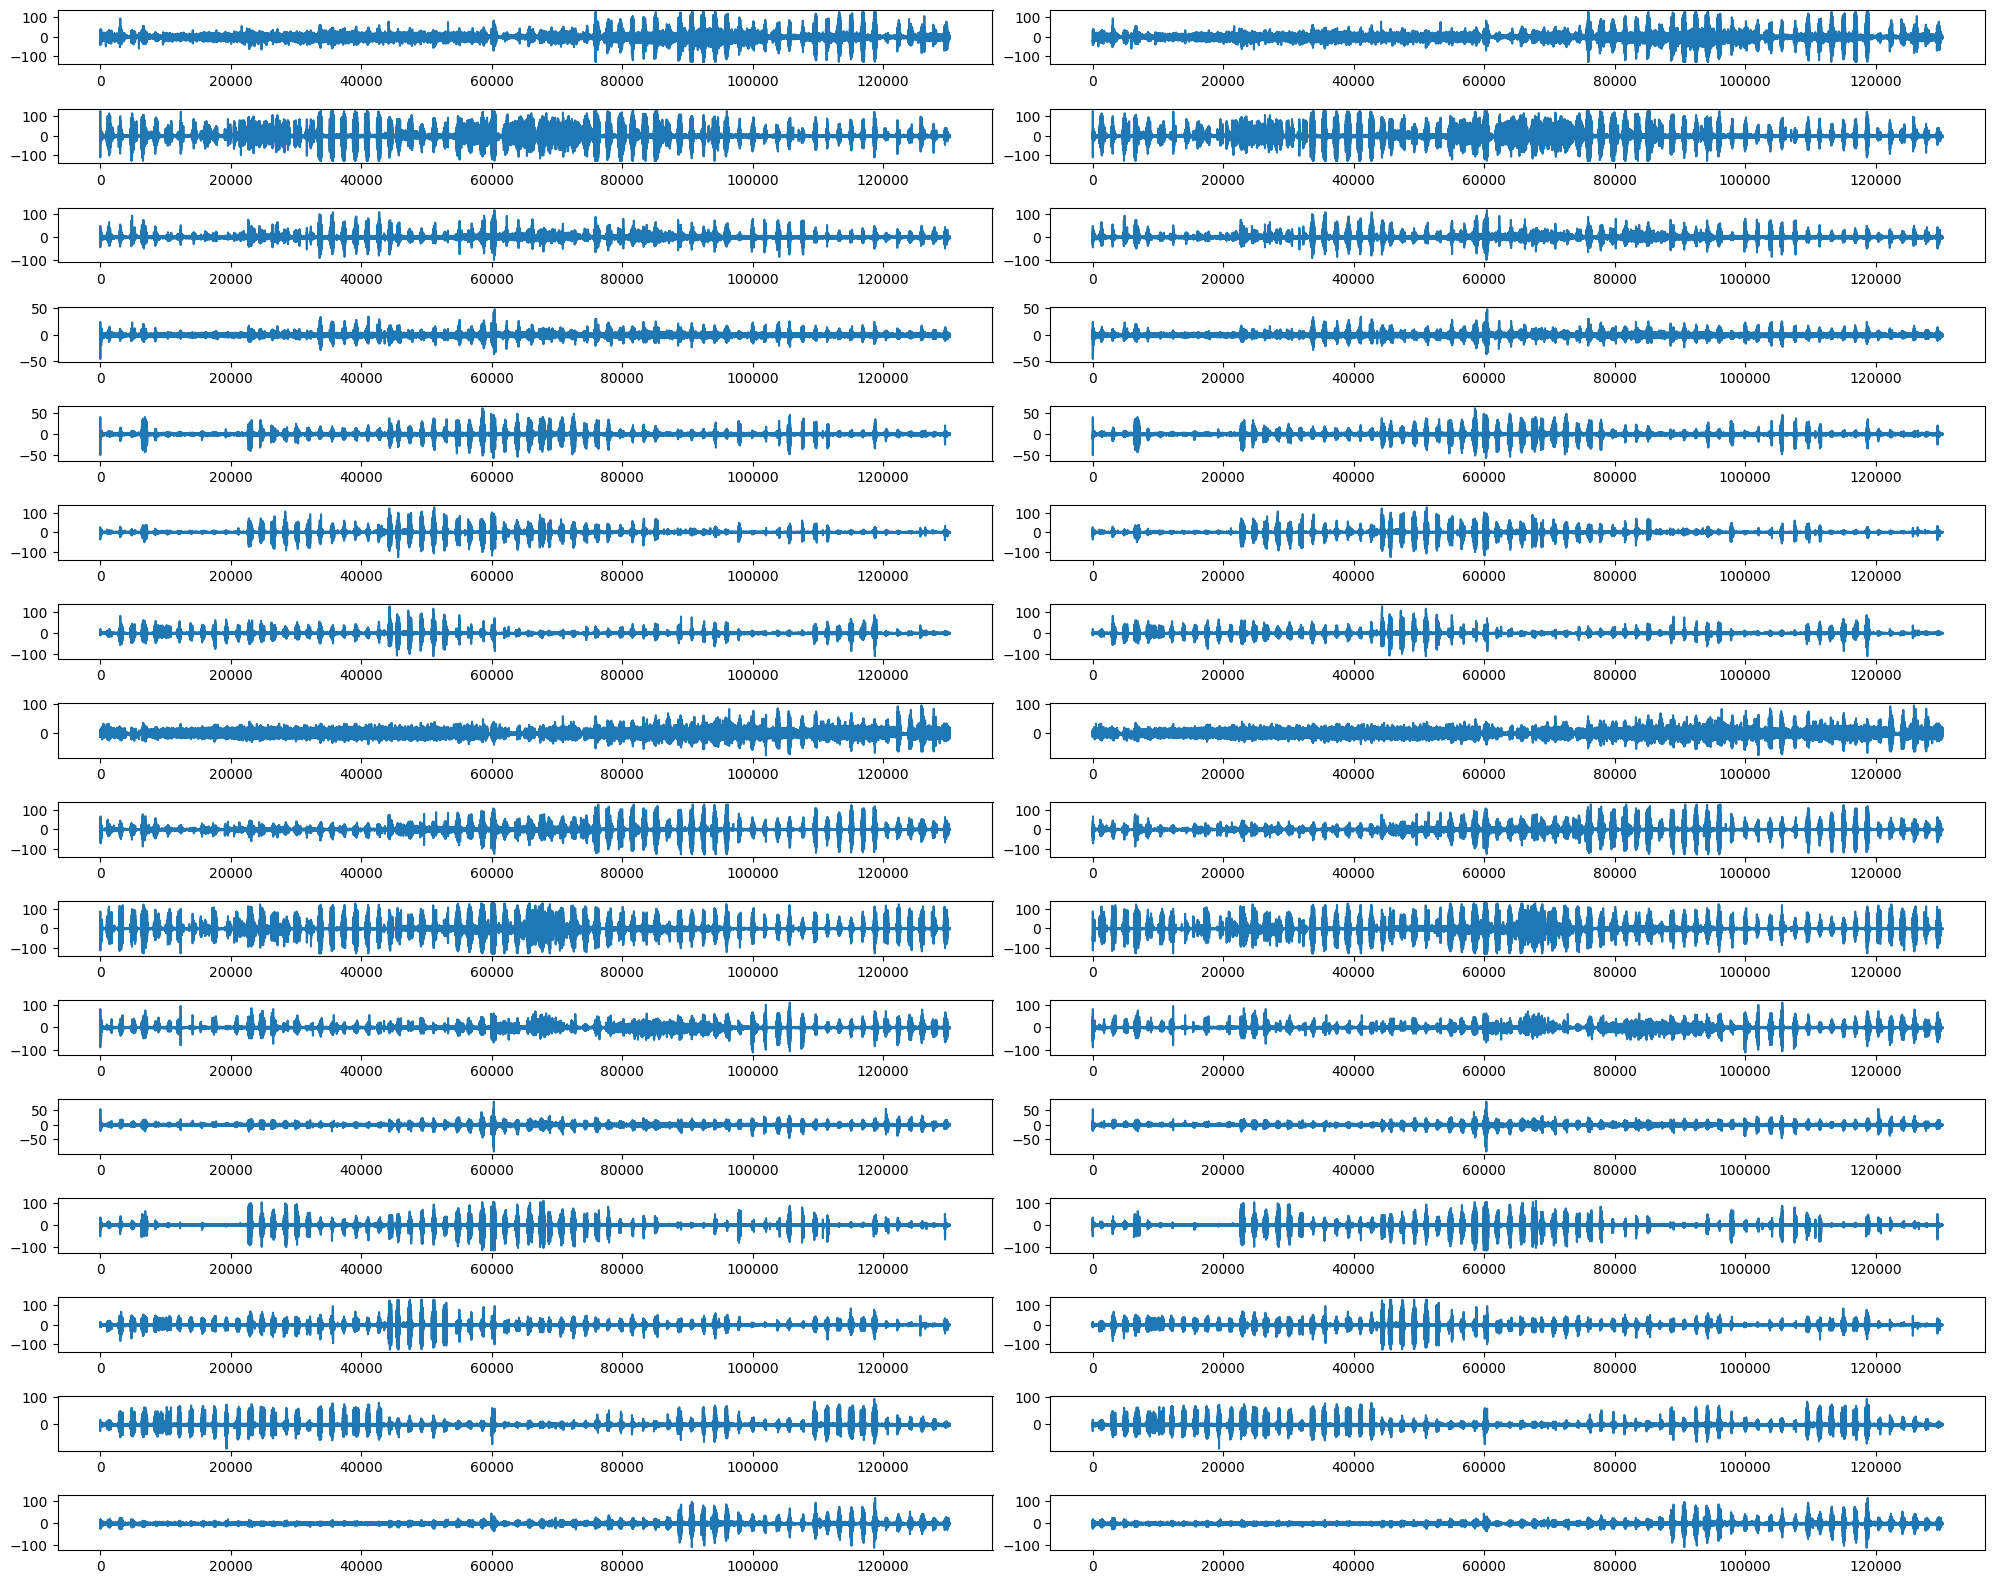

In [ ]:
fig, ax = plt.subplots(16, 2, figsize=(20, 16))
fig.tight_layout()
for i in range(s1_a1['emg'].shape[1]):
    reconstructed_signal = pywt.waverec(transformed_data[i], wavelet)
    ax[i, 0].plot(s1_a1['emg'][:, i])
    ax[i, 1].plot(reconstructed_signal)
plt.show()

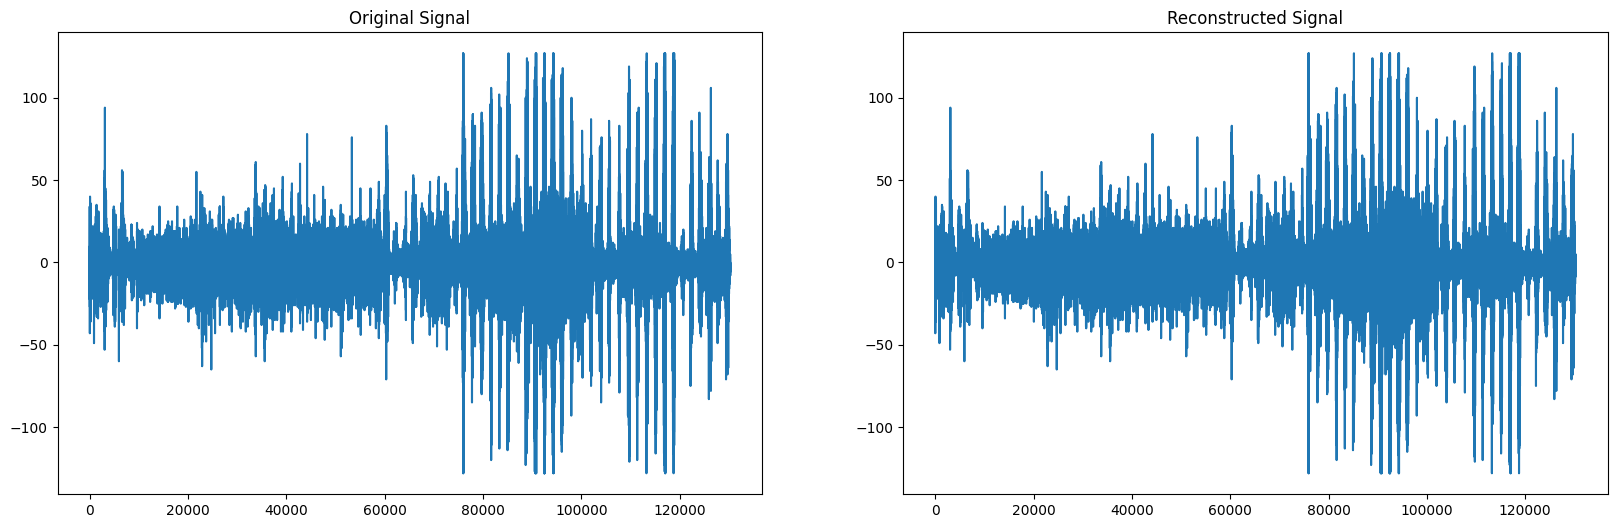

In [ ]:
reconstructed_signal = pywt.waverec(transformed_data[0], wavelet)

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(s1_a1['emg'][:, 0])
plt.title('Original Signal')
plt.subplot(1, 2, 2)
plt.plot(reconstructed_signal)
plt.title('Reconstructed Signal')
plt.show()

[0 1 2 3 4 5 6]
(130267, 1)


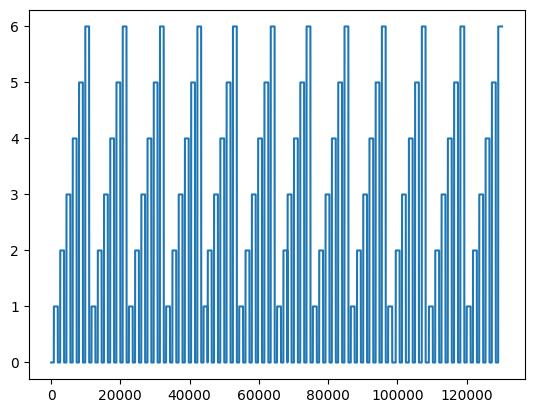

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

print(np.unique(s1_a1['repetition']))
print(s1_a1['repetition'].shape)
plt.plot(s1_a1['repetition'])
plt.show()


### Short Windowed FFT

# ML

## Tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming x has shape (130267, 16) and y has shape (130267, 1)
x = s1_a1["emg"]
y = s1_a1["repetition"]
y = tf.keras.utils.to_categorical(y)

for i in range(x.shape[1]):
    filtered, _ = conv_RMS(x[:, i], time_step)
    x[:, i] = np.pad(filtered, (0, x.shape[0] - filtered.shape[0]), 'constant')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

# Reshape x_train and x_test for Conv1D
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

def create_model(input_shape, classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(64, kernel_size=5, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),

        Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),

        Conv1D(256, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=3),
        Dropout(0.2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(classes, activation='softmax')
    ])
    return model

# Model parameters
num_classes = 7
optimizer = Adam(learning_rate=0.001)
loss = CategoricalCrossentropy()
metrics = [CategoricalAccuracy()]
input_shape = (x_train.shape[1], x_train.shape[2])

# Create and compile the model
tf_model = create_model(input_shape, num_classes)
tf_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train the model
epochs = 10
batch_size = 16
history = tf_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

# Inference
pred = tf_model.predict(x_test)
pred = np.argmax(pred, axis=1)
acc = np.mean(pred == np.argmax(y_test, axis=1))
print(f"Accuracy: {acc}")
tf_model.evaluate(x_test, y_test)

Epoch 1/10
6595/6595 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - categorical_accuracy: 0.4959 - loss: 1.4083 - val_categorical_accuracy: 0.8607 - val_loss: 0.3776
Epoch 2/10
6595/6595 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - categorical_accuracy: 0.7634 - loss: 0.6377 - val_categorical_accuracy: 0.9369 - val_loss: 0.1912
Epoch 3/10
6595/6595 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - categorical_accuracy: 0.8391 - loss: 0.4420 - val_categorical_accuracy: 0.9587 - val_loss: 0.1150
Epoch 4/10
6595/6595 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - categorical_accuracy: 0.8686 - loss: 0.3641 - val_categorical_accuracy: 0.9356 - val_loss: 0.1586
Epoch 5/10
6595/6595 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - categorical_accuracy: 0.8839 - loss: 0.3174 - val_categorical_accuracy: 0.9597 - val_loss: 0.1002
Epoch 6/10
6595/6595 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - categorical_accuracy: 0.8939 - loss: 0.2897 - val_categorical_accuracy: 0.9213 - val_loss: 0.1926
Epoch 7/10
6595/6595 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - categorical_a

[0.08411704003810883, 0.9668381214141846]

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

In [ ]:
s1_a1["emg"].shape

(130267, 16)

In [ ]:
s1_a1["repetition"].shape

(130267, 1)

In [ ]:
x = s1_a1["emg"]
y = s1_a1["repetition"]
y = tf.keras.utils.to_categorical(y)

for i in range(x.shape[1]):
    filtered, _ = conv_RMS(x[:, i], time_step)
    x[:, i] = np.pad(filtered, (0, x.shape[0] - filtered.shape[0]), 'constant')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [ ]:
def create_model(input_shape, classes):
    model = Sequential([
        Dense(32, activation='relu', input_shape=(input_shape,)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(classes, activation='softmax')
    ])
    return model

In [ ]:
num_classes = 7
optimizer = Adam(learning_rate=0.001)
loss = CategoricalCrossentropy()
metrics = [CategoricalAccuracy()]
tf_model = create_model(x_train.shape[1], num_classes)
epochs = 10
batch_size = 16

In [ ]:
tf_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = tf_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/10
6595/6595 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - categorical_accuracy: 0.4046 - loss: 1.5989 - val_categorical_accuracy: 0.6696 - val_loss: 0.9421
Epoch 2/10
6595/6595 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - categorical_accuracy: 0.5339 - loss: 1.2087 - val_categorical_accuracy: 0.7761 - val_loss: 0.6790
Epoch 3/10
6595/6595 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - categorical_accuracy: 0.5843 - loss: 1.0811 - val_categorical_accuracy: 0.8233 - val_loss: 0.5762
Epoch 4/10
6595/6595 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - categorical_accuracy: 0.6158 - loss: 1.0103 - val_categorical_accuracy: 0.8297 - val_loss: 0.5287
Epoch 5/10
6595/6595 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - categorical_accuracy: 0.6399 - loss: 0.9461 - val_categorical_accuracy: 0.8515 - val_loss: 0.4555
Epoch 6/10
6595/6595 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - categorical_accuracy: 0.6581 - loss: 0.8981 - val_categorical_accuracy: 0.8515 - val_loss: 0.4490
Epoch 7/10
6595/6595 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - categorical_a

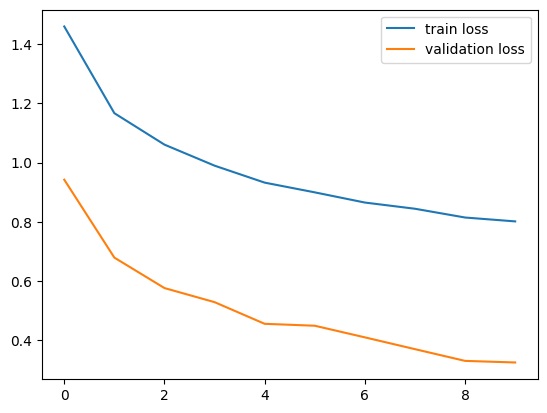

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [ ]:
tf_model.evaluate(x_test, y_test)

408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.8938 - loss: 0.3343


[0.3265228271484375, 0.8972134590148926]

In [ ]:
# Inference
pred = tf_model.predict(x_test)
pred = np.argmax(pred, axis=1)
acc = np.mean(pred == np.argmax(y_test, axis=1))
print(f"Accuracy: {acc}")

408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.8466262378137714


## Pytorch

In [ ]:
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
class EMGDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return x, y


class EMGModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(EMGModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.2)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.softmax(self.fc4(x))
        return x

In [ ]:
x = s1_a1["emg"]
y = s1_a1["repetition"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 16
num_classes = 7
for i in range(x.shape[1]):
    filtered, _ = conv_RMS(x[:, i], time_step)
    x[:, i] = np.pad(filtered, (0, x.shape[0] - filtered.shape[0]), 'constant')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

train_dataset = EMGDataset(x_train, y_train)
test_dataset = EMGDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model = EMGModel(x_train.shape[1], num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
model.to(device)

EMGModel(
  (fc1): Linear(in_features=16, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=7, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.2, inplace=False)
  (batch_norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
from tqdm import tqdm
epochs = 50

for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0.0

    for batch, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        # pred = torch.argmax(pred, dim=1)

        print(pred.shape)
        print(y.shape)

        loss = criterion(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    model.eval()
    with torch.inference_mode():
        test_loss = 0.0
        correct = 0
        total = 0
        for batch, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            pred = model(x)
            pred = torch.argmax(pred, dim=1)
            loss = criterion(pred, y)
            test_loss += loss.item()

            total += y.size(0)
            correct += (pred == y).sum().item()

        test_loss /= len(test_loader)

        accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-82-bed202aad898>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.x[idx], dtype=torch.float32)
<ipython-input-82-bed202aad898>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.y[idx], dtype=torch.float32)
  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([16, 7])
torch.Size([16, 1])


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [ ]:
torch.save(model.state_dict(), 'model.pth')